# Загрузка данных и импорт библиотек

In [1]:
!pip install rapidfuzz
!pip install nltk stop-words
!pip install natasha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=e12fac084c74d8e60847685b988cde80c90fd96727c5fa5018daf7b9ed3a5da7
  Stored in directory: /root/.cache/pip/wheels/8f/a5/51/a5405e1da5d178491b79d12cc81b6cb9bb14fe2c8c632eba70
Successfully built stop-words
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 142.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c0e2568edbb0ec9a5798e8511478d233df3215e228cc51def3508d1607d6c078
  Stored in directory: /root/.cach

In [1]:
import json
import bz2
import regex
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stop_words import get_stop_words
from razdel import tokenize

from google.colab import drive
drive.mount('/content/drive')

from natasha import (
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger,
    MorphVocab,
    Doc
)
from rapidfuzz import process, fuzz

%matplotlib inline
%pylab inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Populating the interactive namespace from numpy and matplotlib


In [65]:
responses = []
with bz2.BZ2File('/content/drive/MyDrive/Colab Notebooks/ds/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:04, 3115.99it/s]



Посмотрим на пример отзыва:

In [66]:
responses[3]

{'city': 'г. Ставрополь',
 'rating_not_checked': False,
 'title': 'Меняют проценты комиссии  не предупредив и не известив клиентов!!',
 'num_comments': 2,
 'bank_license': 'лицензия № 1481',
 'author': '643609',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-06-05 13:51:01',
 'text': 'Добрый день!! Я открыл расчетный счет в СберБанке, как Юр. лицо.. Все было бы хорошо если бы не одно НО.....\xa0 По договору НЕ берется комиссии за перевод денежных средств со счета Юр. лица на счет физ.лица, эти условия сохранялись 4 месяца. Каким же было мое удивление когда при проведении очередной операции перевода денег со счета списали комиссию в 1 % !!!!\xa0\xa0 Я понимаю что Банк вправе изменить процентные ставки и размер комиссии,  но не предупредив,не известив меня об этом  это как? Что за отношение к клиентам? Получается, я потерял не малую сумму денег, только по тому что банк не удосужился меня известить!!! А завтра еще какое нибудь условие изменится и я еще и должен останусь!!! За обслужи

In [67]:
import random
random.seed(1)

In [68]:
# Для ускорения вычислений в дальнейшем возьму 25% случайных данных
random_sample = random.choices(responses, k=int(len(responses) * 0.25))
# Преобразование в pd.DataFrame
df = pd.DataFrame(random_sample)

In [69]:
# Приведение текстовых параметров в нижний регистр
text_col = ['city', 'title', 'bank_name', 'text']
for col in text_col:
    df[col] = df[col].str.lower()

# Часть 1 Анализ текстов

## Обработка и анализ по городам

Получение списка населенных пунктов в России

In [70]:
# Загружаем CSV со списком населённых пунктов России
url = (
    "https://raw.githubusercontent.com/"
    "epogrebnyak/ru-cities/main/assets/towns.csv"
)
df_towns = pd.read_csv(url)

# Делаем все строки в нижнем регистре
df_towns['city'] = df_towns['city'].str.lower()

# Только уникальные названия городов
city_list = df_towns['city'].unique().tolist()

print('Количество уникальных значений:{}'.format(len(city_list)))

Количество уникальных значений:1097


In [71]:
def remove_g_prefix(text):
    '''
    Функция приведения названия города к стандартному виду без
    сокращений и дополнительных указателей
    '''
    return re.sub(r'\bг(?:\s*\.\s*)+(?=[\w-])', '', text.strip())

Проверка на сокращения в городах

In [72]:
short_forms = {}
for val in df['city'].dropna():
    cleaned = remove_g_prefix(val)
    if len(cleaned) <= 3:
        short_forms[cleaned] = short_forms.get(cleaned, 0) + 1

# Отбор только часто встречающихся сокращений
short_forms = {k: v for k, v in short_forms.items() if v >= 3}
print(f'Возможные аббревиатуры:{short_forms.keys()}')

Возможные аббревиатуры:dict_keys(['спб', 'уфа', 'мск', 'бор', 'spb'])


In [73]:
# Сортировка по длине, чтобы город с припиской проверялся раньше.
# Пример: комсомольск-на-амуре не комсомольск (Ивановская обл.)
city_list = sorted(city_list, key=lambda x: -len(x))


# Словарь сокращений
aliases = {
    'мск': 'москва',
    'спб': 'санкт-петербург',
    'spb': 'санкт-петербург'
}
# —————————— Функции ———————————————

# Поиск названий по похожести threshold=85
def extract_city_with_fuzzy(text, city_list, aliases, threshold=85):
    if pd.isna(text) or not isinstance(text, str):
        return None
    cleaned = remove_g_prefix(text)

    # Проверяем alias
    for alias, full in aliases.items():
        if alias in cleaned:
            return full

    # Пробуем точное совпадение в списке городов
    for city in city_list:
        if city in cleaned:
            return city

    # Fuzzy matching (частичное сравнение)
    match = process.extractOne(cleaned, city_list, scorer=fuzz.partial_ratio)
    if match and match[1] >= threshold:
        return match[0]

    return None

In [74]:
df['city_clear'] = df['city'].apply(lambda x: extract_city_with_fuzzy(x, city_list, aliases))

In [75]:
print(f'Уникальных значений городов до обработки {df.city.nunique()} \nПосле обработки {df.city_clear.nunique()}')

Уникальных значений городов до обработки 1831 
После обработки 673


Группировка по городам и банкам

In [76]:
df_grouped = df.groupby(['city_clear', 'bank_name'])['bank_name'].count().reset_index(name='count')

Визуализация по городам и банкам

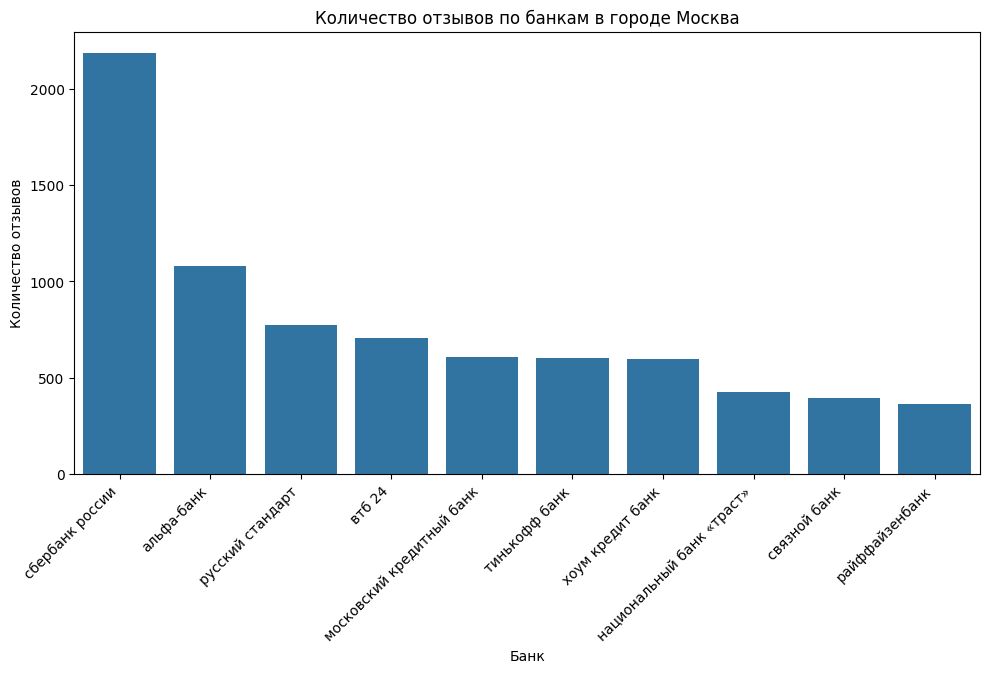

In [77]:
find_city = 'москва'

df_city = df_grouped[(df_grouped['city_clear'] == find_city)].sort_values(by='count',ascending=False).head(10)

# График
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_city.sort_values('count', ascending=False),
    x='bank_name',
    y='count'
)

plt.title(f'Количество отзывов по банкам в городе {find_city.capitalize()}')
plt.xlabel('Банк')
plt.ylabel('Количество отзывов')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

## Гистограмы длин слов в символах и в словах

In [78]:
df['len_symbols'] = df['text'].str.len()
df['len_words'] = df['text'].apply(lambda x: len(re.sub(r'[^\w\s]', '', x).split()))

In [79]:
df[['len_words','len_symbols']].head()

,len_words,len_symbols
0,106,742
1,139,905
2,591,4013
3,176,1099
4,163,1169


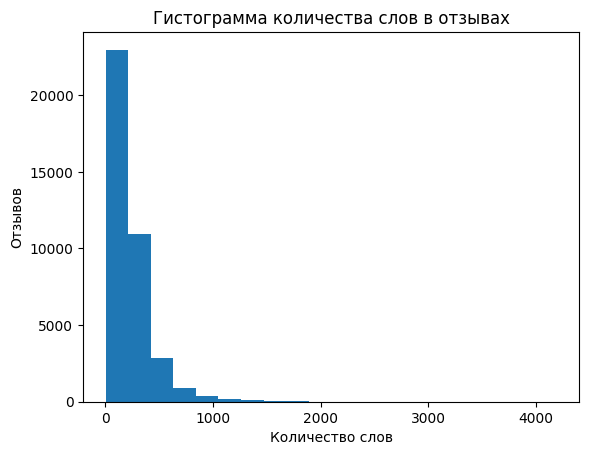

In [80]:
plt.hist(df['len_words'], bins=20)


plt.title('Гистограмма количества слов в отзывах')
plt.xlabel('Количество слов')
plt.ylabel('Отзывов')

plt.show()

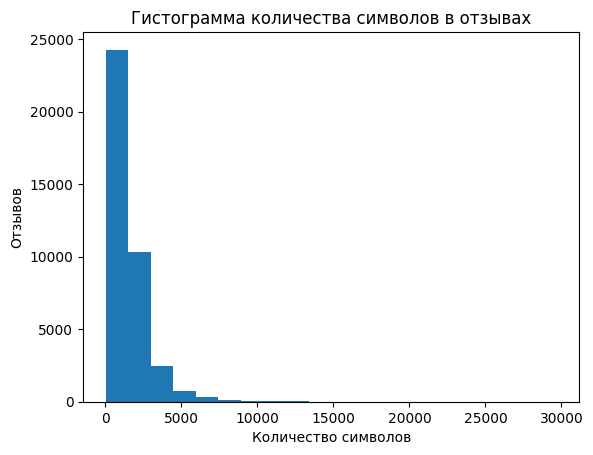

In [81]:
plt.hist(df['len_symbols'], bins=20)


plt.title('Гистограмма количества символов в отзывах')
plt.xlabel('Количество символов')
plt.ylabel('Отзывов')

plt.show()

## 10 самых частых:

### Слов

Токенизация

In [82]:
def tokenize_clean(text):
    tokens = [t.text for t in tokenize(text)]
    return [t for t in tokens if re.fullmatch(r'\w+', t)]

In [83]:
df['tokens'] = df['text'].apply(tokenize_clean)

In [84]:
all_tokens = (
    df['tokens']
    .explode()
    .value_counts()
    .reset_index()
    .sort_values(by='count',ascending=False)
)

all_tokens.head(10)

,tokens,count
0,в,331698
1,и,263946
2,не,213347
3,на,176434
4,что,155698
5,я,144370
6,с,114892
7,по,91146
8,мне,80624
9,банка,65634


In [85]:
df.tokens.head()

,tokens
0,"[в, данный, банк, никогда, не, обращался, тепе..."
1,"[в, продолжение, истории, зашёл, вчера, в, бан..."
2,"[относительно, недавно, в, появился, новый, ра..."
3,"[года, оплатил, в, филиале, сбербанка, 9038, 1..."
4,"[используем, онлайн, для, юридических, лиц, от..."


### Слов без стоп-слов

Удаление стоп слов и обновление токенов

In [86]:
# Русские стоп-слова
stopwords = set(get_stop_words('russian'))

# Фильтр токенов: только слова, не цифры, не стоп-слова
def filter_tokens(tokens):
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if not re.fullmatch(r'\d+', t)]
    return tokens

In [87]:
df['tokens'] = df['tokens'].apply(filter_tokens)

In [88]:
no_sw_tokens = (
    df['tokens']
    .explode()
    .value_counts()
    .reset_index()
    .sort_values(by='count', ascending=False)
)

In [89]:
no_sw_tokens.head(10)

,tokens,count
0,банка,65634
1,банк,49288
2,деньги,32666
3,карту,26182
4,карты,25418
5,кредит,20082
6,заявление,17517
7,отделение,16632
8,банке,16371
9,счет,14379


### Леммы

Лемматизация

In [90]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_clear,len_symbols,len_words,tokens
0,г. северодвинск,False,странный банк,1,лицензия № 1460,planar,восточный экспресс банк,2014-12-24 22:09:00,в данный банк никогда не обращался. теперь ист...,NaN,северодвинск,742,106,"[данный, банк, обращался, история, позвонили, ..."
1,г. москва,False,снова положительные эмоции от работы сотрудников,0,лицензия № 2275,bp-alex,уралсиб,2010-10-26 10:04:00,в продолжение истории зашёл вчера в банк за ...,NaN,москва,905,139,"[продолжение, истории, зашёл, вчера, банк, кар..."
2,г. омск,False,"""предложения для вас"" от райффайзен банка",7,лицензия № 3292,TemOFFey,райффайзенбанк,2011-11-08 07:29:00,относительно недавно в райффайзен-коннект (инт...,1.0,москва,4013,591,"[относительно, появился, новый, раздел, предло..."


In [143]:
# словарь токенов для подачи Natasha
df['tokens_str'] = df['tokens'].apply(lambda x: ' '.join(x))

In [144]:
# Natasha объекты
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

# Получение существительных и лемматизация
def lemmatize_and_extract_nouns(text: str):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    lemmas = [token.lemma for token in doc.tokens]
    nouns = [token.lemma for token in doc.tokens if token.pos == 'NOUN']
    return lemmas, nouns

In [93]:
df[['lemmas', 'nouns']] = df['tokens_str'].apply(
    lambda text: pd.Series(lemmatize_and_extract_nouns(text)))

In [94]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_clear,len_symbols,len_words,tokens,tokens_str,lemmas,nouns
0,г. северодвинск,False,странный банк,1,лицензия № 1460,planar,восточный экспресс банк,2014-12-24 22:09:00,в данный банк никогда не обращался. теперь ист...,NaN,северодвинск,742,106,"[данный, банк, обращался, история, позвонили, ...",данный банк обращался история позвонили конце ...,"[данный, банк, обращаться, история, позвонить,...","[банк, история, конец, август, предложение, кр..."
1,г. москва,False,снова положительные эмоции от работы сотрудников,0,лицензия № 2275,bp-alex,уралсиб,2010-10-26 10:04:00,в продолжение истории зашёл вчера в банк за ...,NaN,москва,905,139,"[продолжение, истории, зашёл, вчера, банк, кар...",продолжение истории зашёл вчера банк картами з...,"[продолжение, история, зайти, вчера, банк, кар...","[продолжение, история, банк, карта, дебетовка,..."
2,г. омск,False,"""предложения для вас"" от райффайзен банка",7,лицензия № 3292,TemOFFey,райффайзенбанк,2011-11-08 07:29:00,относительно недавно в райффайзен-коннект (инт...,1.0,москва,4013,591,"[относительно, появился, новый, раздел, предло...",относительно появился новый раздел предложения...,"[относительно, появиться, новый, раздел, предл...","[раздел, предложение, раздел, предложение, офо..."
3,г. москва,False,отправили деньги на неверный № счета и не хотя...,6,лицензия № 1481,zhenya,сбербанк россии,2014-07-30 10:04:00,15.04.14 года оплатил в филиале сбербанка № 90...,NaN,москва,1099,176,"[оплатил, филиале, сбербанка, налог, имущество...",оплатил филиале сбербанка налог имущество мать...,"[оплатить, филиал, сбербанк, налог, имущество,...","[филиал, сбербанк, имущество, платеж, оператор..."
4,г. москва,False,не проходят платежки в банк-клиенте,1,лицензия № 1623,pupovdanil,втб 24,2013-08-22 03:51:00,используем банк-клиент онлайн для юридических ...,1.0,москва,1169,163,"[используем, онлайн, юридических, лиц, отправи...",используем онлайн юридических лиц отправил бко...,"[использовать, онлайн, юридический, лицо, отпр...","[лицо, банк, платежка, платежка, статус, деньг..."


In [95]:
# Топ 10 лемм
df['lemmas'].explode().value_counts().reset_index().sort_values(by='count', ascending=False).head(10)

,lemmas,count
0,банк,154543
1,карта,83345
2,деньга,44692
3,кредит,38821
4,отделение,35972
5,счет,35844
6,сотрудник,33612
7,клиент,33197
8,мой,32492
9,сумма,27622


### Существительные

In [96]:
df['nouns'].explode().value_counts().reset_index().sort_values(by='count', ascending=False).head(10)

,nouns,count
0,банк,154196
1,карта,82979
2,деньга,44674
3,кредит,38664
4,счет,35722
5,отделение,35614
6,сотрудник,33588
7,клиент,33155
8,сумма,27598
9,заявление,25782


## Графики Ципфа и Хипсса

In [98]:
all_lemmas = (
    df['lemmas']
    .explode()
    .value_counts()
    .reset_index()
)

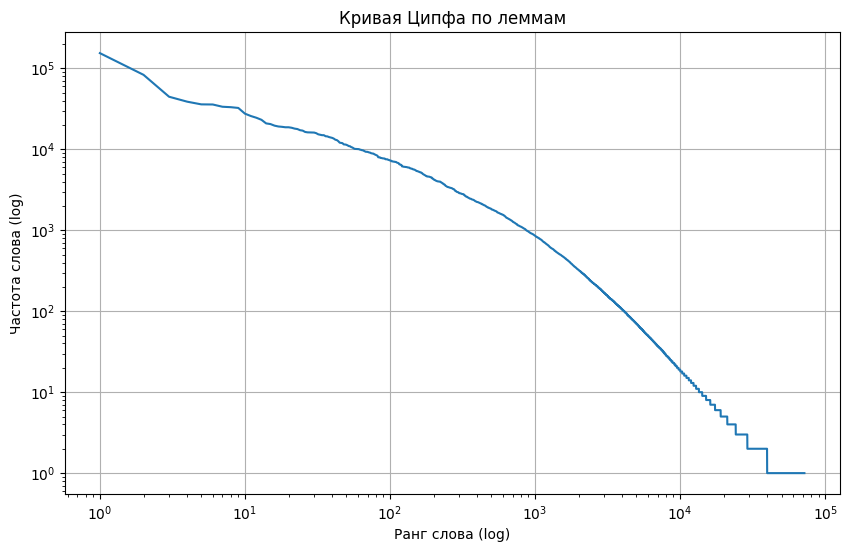

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(all_lemmas) + 1), all_lemmas['count'])
plt.xscale('log')
plt.yscale('log')
plt.title('Кривая Ципфа по леммам')
plt.xlabel('Ранг слова (log)')
plt.ylabel('Частота слова (log)')
plt.grid(True)
plt.show()

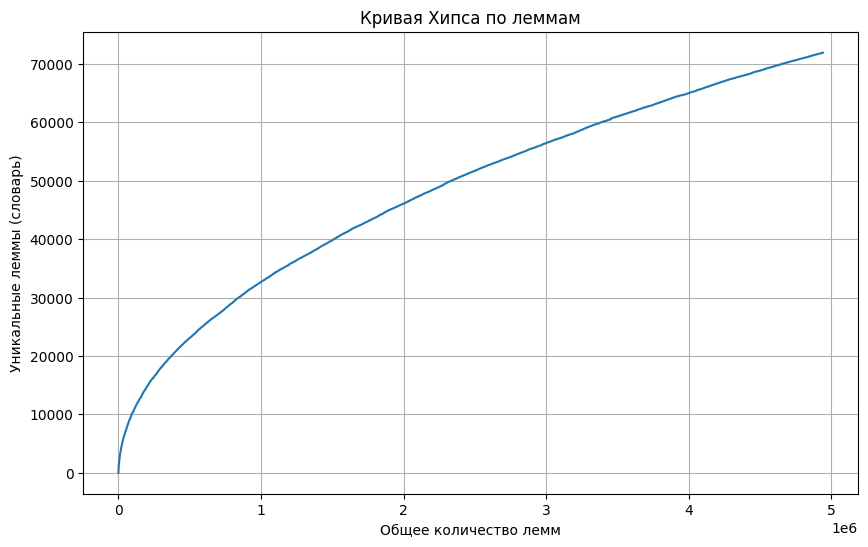

In [100]:
all_lemmas_seq = [lemma for row in df['lemmas'] for lemma in row]

unique = set()
total_tokens = []
vocab_size = []

for i, lemma in enumerate(all_lemmas_seq, 1):
    unique.add(lemma)
    total_tokens.append(i)
    vocab_size.append(len(unique))

plt.figure(figsize=(10, 6))
plt.plot(total_tokens, vocab_size)
plt.title('Кривая Хипса по леммам')
plt.xlabel('Общее количество лемм')
plt.ylabel('Уникальные леммы (словарь)')
plt.grid(True)
plt.show()


## Поиск частоты определенных слов

Какое слово встречается чаще, "сотрудник" или "клиент"?
сколько раз встречается слова "мошенничество" и "доверие"?

Чаще сотрудник

In [101]:
all_lemmas.query('lemmas == "клиент"')

,lemmas,count
7,клиент,33197


In [102]:
all_lemmas.query('lemmas == "сотрудник"')

,lemmas,count
6,сотрудник,33612


мошенничество 800 раз

In [103]:
all_lemmas.query('lemmas == "мошенничество"')

,lemmas,count
1059,мошенничество,800


доверие 536 раз

In [104]:
all_lemmas.query('lemmas == "доверие"')

,lemmas,count
1409,доверие,536


## TF-IDF

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру
t
f
−
i
d
f
, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [105]:
df['lemmas'] = df['lemmas'].apply(lambda x: ' '.join(x))

In [106]:
pos_rate = df[(df['rating_grade'].notna()) & (df['rating_grade'] == 5)]
neg_rate = df[(df['rating_grade'].notna()) & (df['rating_grade'] == 1)]

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [108]:
tfidf_pos_rate = vectorizer.fit_transform(pos_rate['lemmas'])

tfidf_sum = np.asarray(tfidf_pos_rate.sum(axis=0)).flatten()

tfidf_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'tfidf': tfidf_sum
}).sort_values(by='tfidf', ascending=False)

# Топ 10 ключевых слов для позитивных отзывов
print(tfidf_df.head(10))

            term       tfidf
1830        банк  295.153049
7181       карта  182.381539
2923       вклад  135.892618
7999      кредит  132.089508
12142  отделение  120.374413
7399      клиент  103.917622
18637  сотрудник  103.332864
4565      деньга   98.595259
12493       офис   95.608819
3209      вопрос   90.097200


In [109]:
tfidf_neg_rate = vectorizer.fit_transform(neg_rate['lemmas'])

tfidf_sum = np.asarray(tfidf_neg_rate.sum(axis=0)).flatten()

tfidf_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'tfidf': tfidf_sum
}).sort_values(by='tfidf', ascending=False)

# Топ 10 ключевых слов для негативных отзывов
print(tfidf_df.head(10))

            term       tfidf
4621        банк  877.353611
14198      карта  728.853922
9568      деньга  470.477249
15551     кредит  409.886336
22852  отделение  388.171419
35403       счет  372.425118
12680  заявление  334.883087
34306  сотрудник  333.936162
14551     клиент  294.286931
17552        мой  288.499509


In [110]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=5)

tfidf_bigrams_pos_rate = vectorizer.fit_transform(pos_rate['lemmas'])
tfidf_sum = np.asarray(tfidf_bigrams_pos_rate.sum(axis=0)).flatten()

tfidf_df = pd.DataFrame({
    'bigram': vectorizer.get_feature_names_out(),
    'tfidf': tfidf_sum
}).sort_values(by='tfidf', ascending=False)

# Топ 10 ключевых биграмм для позитивных отзывов
print(tfidf_df.head(10))

                bigram      tfidf
3903   кредитный карта  51.102317
8450    сотрудник банк  50.379772
3465       клиент банк  39.455447
5421    отделение банк  34.775149
9679   являться клиент  31.574991
5624     открыть вклад  30.478094
2516       другой банк  29.551679
1977   дебетовый карта  25.220869
9468   хотеть выразить  24.267362
5693  отношение клиент  23.880924


In [111]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=5)

tfidf_bigrams_neg_rate = vectorizer.fit_transform(neg_rate['lemmas'])
tfidf_sum = np.asarray(tfidf_bigrams_neg_rate.sum(axis=0)).flatten()

tfidf_df = pd.DataFrame({
    'bigram': vectorizer.get_feature_names_out(),
    'tfidf': tfidf_sum
}).sort_values(by='tfidf', ascending=False)

# Топ 10 ключевых биграмм для негативных отзывов
print(tfidf_df.head(10))

                   bigram       tfidf
41433      сотрудник банк  143.955283
17658     кредитный карта  119.094628
25959      отделение банк  109.147584
7794    денежный средство  106.160168
20550  написать заявление  102.662997
6473        горячий линия   94.331317
15921         клиент банк   70.224715
40120    служба поддержка   69.343445
3123             ваш банк   67.047609
36249        рабочий день   65.025841


# Часть 2. Тематическое моделирование

In [ ]:
!pip -q install scipy==1.12.0
!pip -q install gensim==4.3.2

Использую gensim

In [6]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import LdaModel

## Разделение на темы и поиск подходящего количества тем

In [8]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_clear,len_symbols,len_words,tokens,tokens_str,lemmas,nouns
0,г. северодвинск,False,странный банк,1,лицензия № 1460,planar,восточный экспресс банк,2014-12-24 22:09:00,в данный банк никогда не обращался. теперь ист...,NaN,северодвинск,742,106,"[данный, банк, обращался, история, позвонили, ...",данный банк обращался история позвонили конце ...,данный банк обращаться история позвонить конец...,"[банк, история, конец, август, предложение, кр..."
1,г. москва,False,снова положительные эмоции от работы сотрудников,0,лицензия № 2275,bp-alex,уралсиб,2010-10-26 10:04:00,в продолжение истории зашёл вчера в банк за ...,NaN,москва,905,139,"[продолжение, истории, зашёл, вчера, банк, кар...",продолжение истории зашёл вчера банк картами з...,продолжение история зайти вчера банк карта зао...,"[продолжение, история, банк, карта, дебетовка,..."
2,г. омск,False,"""предложения для вас"" от райффайзен банка",7,лицензия № 3292,TemOFFey,райффайзенбанк,2011-11-08 07:29:00,относительно недавно в райффайзен-коннект (инт...,1.0,москва,4013,591,"[относительно, появился, новый, раздел, предло...",относительно появился новый раздел предложения...,относительно появиться новый раздел предложени...,"[раздел, предложение, раздел, предложение, офо..."
3,г. москва,False,отправили деньги на неверный № счета и не хотя...,6,лицензия № 1481,zhenya,сбербанк россии,2014-07-30 10:04:00,15.04.14 года оплатил в филиале сбербанка № 90...,NaN,москва,1099,176,"[оплатил, филиале, сбербанка, налог, имущество...",оплатил филиале сбербанка налог имущество мать...,оплатить филиал сбербанк налог имущество мать ...,"[филиал, сбербанк, имущество, платеж, оператор..."
4,г. москва,False,не проходят платежки в банк-клиенте,1,лицензия № 1623,pupovdanil,втб 24,2013-08-22 03:51:00,используем банк-клиент онлайн для юридических ...,1.0,москва,1169,163,"[используем, онлайн, юридических, лиц, отправи...",используем онлайн юридических лиц отправил бко...,использовать онлайн юридический лицо отправить...,"[лицо, банк, платежка, платежка, статус, деньг..."


Создание словаря и корпуса doc2bow

In [11]:
texts = [text for text in df['lemmas'].str.split()]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Функция построения модели с указанием количества тем

In [12]:
def build_lda_model(num_topics):
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        iterations=100
    )
    return lda


Поиск наиболее подходящего количества тем

In [13]:
topic_numbers = [3, 5, 7]
models = {}
topics_summary = {}

for k in topic_numbers:
    print(f'--- Модель с {k} темами ---')
    lda_k = build_lda_model(k)
    models[k] = lda_k
    topics = lda_k.print_topics(num_words=6)
    topics_summary[k] = topics
    for i, topic in topics:
        print(f'Тема {i+1}: {topic}')
    print('\n')

--- Модель с 3 темами ---
Тема 1: 0.028*"банк" + 0.018*"карта" + 0.012*"отделение" + 0.010*"клиент" + 0.009*"деньга" + 0.009*"вклад"
Тема 2: 0.030*"карта" + 0.028*"банк" + 0.017*"счет" + 0.015*"деньга" + 0.013*"заявление" + 0.011*"средство"
Тема 3: 0.037*"банк" + 0.027*"кредит" + 0.010*"сотрудник" + 0.010*"кредитный" + 0.010*"сумма" + 0.009*"договор"


--- Модель с 5 темами ---
Тема 1: 0.030*"банк" + 0.013*"клиент" + 0.012*"вклад" + 0.012*"отделение" + 0.009*"офис" + 0.008*"сотрудник"
Тема 2: 0.037*"банк" + 0.014*"счет" + 0.013*"средство" + 0.011*"договор" + 0.011*"данный" + 0.010*"мой"
Тема 3: 0.039*"банк" + 0.024*"кредит" + 0.015*"платеж" + 0.012*"сотрудник" + 0.012*"звонок" + 0.011*"сумма"
Тема 4: 0.052*"карта" + 0.024*"банк" + 0.020*"деньга" + 0.014*"счет" + 0.010*"банкомат" + 0.010*"заявление"
Тема 5: 0.038*"кредит" + 0.032*"банк" + 0.018*"документ" + 0.017*"заявка" + 0.014*"договор" + 0.012*"кредитный"


--- Модель с 7 темами ---
Тема 1: 0.030*"банк" + 0.017*"вклад" + 0.015*"клие

Легче интерпретировать модель с 7 темами

In [14]:
lda_7 = models[7]

In [15]:
def get_main_topic(bow):
    topics = lda_7.get_document_topics(bow)
    if topics:
        return max(topics, key=lambda x: x[1])[0]
    return None

# Создание словаря topic_id → ключевые слова
topic_keywords = {
    i: ', '.join([word for word, _ in lda_7.show_topic(i, topn=5)])
    for i in range(7)
}

# Получение топиков
df['main_topic_lda7'] = [get_main_topic(doc) for doc in corpus]

# Добавление ключевых слов темы
df['main_topic_keywords'] = df['main_topic_lda7'].map(topic_keywords)

Инерпретация тем

In [16]:
keywords = [re.findall(r'"(.*?)"', topics[i][1]) for i in range(7)]

In [17]:
keywords =[', '.join(words[:5]) for words in keywords]
keywords

['банк, вклад, клиент, отделение, офис',
 'банк, средство, счет, договор, данный',
 'карта, банк, счет, комиссия, кредитный',
 'карта, деньга, банк, счет, заявление',
 'кредит, сумма, банк, платеж, договор',
 'банк, сотрудник, звонок, телефон, номер',
 'заявка, банк, документ, _, кредит']

Интерпретации тем:

Тема 0:       Оформление вкладов и работа отделений

Тема 1:       Договоры, счета и движение средств

Тема 2:       Комиссии и обслуживание банковских карт

Тема 3:       Проблемы с картами, деньгами и заявлениями

Тема 4:       Погашение кредита и платёжные вопросы

Тема 5:       Телефонные звонки и работа сотрудников

Тема 6:       Кредитные заявки и документы


In [24]:
topic_data = {
    'topic_id': list(range(7)),
    'keywords': keywords,
    'interpretation': [
    'Оформление вкладов и работа отделений',
    'Договоры, счета и движение средств',
    'Комиссии и обслуживание банковских карт',
    'Проблемы с картами, деньгами и заявлениями',
    'Погашение кредита и платёжные вопросы',
    'Телефонные звонки и работа сотрудников',
    'Кредитные заявки и документы'
    ]
}

topics_df = pd.DataFrame(topic_data)

In [25]:
topics_df

,topic_id,keywords,interpretation
0,0,"банк, вклад, клиент, отделение, офис",Оформление вкладов и работа отделений
1,1,"банк, средство, счет, договор, данный","Договоры, счета и движение средств"
2,2,"карта, банк, счет, комиссия, кредитный",Комиссии и обслуживание банковских карт
3,3,"карта, деньга, банк, счет, заявление","Проблемы с картами, деньгами и заявлениями"
4,4,"кредит, сумма, банк, платеж, договор",Погашение кредита и платёжные вопросы
5,5,"банк, сотрудник, звонок, телефон, номер",Телефонные звонки и работа сотрудников
6,6,"заявка, банк, документ, _, кредит",Кредитные заявки и документы


Присоединяю номер темы и ее интерпретацию к датафрейму

In [30]:
df = df.merge(
    topics_df[['topic_id', 'interpretation']],
    left_on='main_topic_lda7',
    right_on='topic_id',
    how='left'
)
df.drop(columns='topic_id', inplace=True)
df.rename(columns={'interpretation': 'main_topic_interpretation'}, inplace=True)

In [32]:
df.head(2)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_clear,len_symbols,len_words,tokens,tokens_str,lemmas,nouns,main_topic_lda7,main_topic_keywords,main_topic_interpretation
0,г. северодвинск,False,странный банк,1,лицензия № 1460,planar,восточный экспресс банк,2014-12-24 22:09:00,в данный банк никогда не обращался. теперь ист...,NaN,северодвинск,742,106,"[данный, банк, обращался, история, позвонили, ...",данный банк обращался история позвонили конце ...,данный банк обращаться история позвонить конец...,"[банк, история, конец, август, предложение, кр...",5,"банк, сотрудник, звонок, телефон, номер",Телефонные звонки и работа сотрудников
1,г. москва,False,снова положительные эмоции от работы сотрудников,0,лицензия № 2275,bp-alex,уралсиб,2010-10-26 10:04:00,в продолжение истории зашёл вчера в банк за ...,NaN,москва,905,139,"[продолжение, истории, зашёл, вчера, банк, кар...",продолжение истории зашёл вчера банк картами з...,продолжение история зайти вчера банк карта зао...,"[продолжение, история, банк, карта, дебетовка,...",0,"банк, вклад, клиент, отделение, офис",Оформление вкладов и работа отделений


## Темы, в которых упомянуты конкретные банки

In [36]:
def get_bank_comments(bank_name):
    mask = df['tokens_str'].str.contains(bank_name, case=False, na=False)
    filtered = df[mask]

    counts = filtered['main_topic_interpretation'].value_counts()
    bank_comment = counts.reset_index().rename(columns={'main_topic_interpretation': 'Тема комментария', 'count': 'Количество'})
    sum_counts = bank_comment['Количество'].sum()

    return bank_comment, sum_counts

In [37]:
bank_list = ['Россельхозбанк', 'Газпромбанк', 'Промсвязьбанк']

У каждого банка свои основные темы

In [41]:
for bank in bank_list:
    print(get_bank_comments(bank)[0],'\n')
    print(f'\t\t\t    Всего упоминаний: {get_bank_comments(bank)[1]}')
    print('_' * 58)

                             Тема комментария  Количество
0       Оформление вкладов и работа отделений          33
1                Кредитные заявки и документы          16
2  Проблемы с картами, деньгами и заявлениями          14
3          Договоры, счета и движение средств          12
4       Погашение кредита и платёжные вопросы           8
5      Телефонные звонки и работа сотрудников           4
6     Комиссии и обслуживание банковских карт           1 

			    Всего упоминаний: 88
__________________________________________________________
                             Тема комментария  Количество
0                Кредитные заявки и документы          32
1  Проблемы с картами, деньгами и заявлениями          30
2       Оформление вкладов и работа отделений          18
3      Телефонные звонки и работа сотрудников          11
4     Комиссии и обслуживание банковских карт          10
5          Договоры, счета и движение средств           6
6       Погашение кредита и платёжные воп

# Часть 3. Классификация текстов

## Обучающее и тестовое множество

In [132]:
df_model = df[(df['rating_grade'] == 1) | (df['rating_grade'] == 5)].sample(5000, random_state=777).copy()

In [133]:
df_model['rating_grade'].value_counts()

,count
rating_grade,
1.0,3731
5.0,1269


In [49]:
from sklearn.model_selection import train_test_split

In [116]:
df_model[['lemmas', 'rating_grade']].head()

,lemmas,rating_grade
15725,являться клиент банк октябрь прошлое получать ...,5.0
9319,ужасный обслуживание доп офис несмотря официал...,1.0
12520,фон общий настроение день го ранний утро декаб...,5.0
24814,получать страховой возмещение втб открыть вкла...,1.0
11532,день пытаться дозвониться оператор банк заглян...,1.0


In [58]:
X =df_model['lemmas']
y = df_model['rating_grade']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=777)

## Pipeline для оценки векторизации с разными n-граммами

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier


clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,2))),
    ('clf', RandomForestClassifier(random_state=777)),
])

In [106]:
res = clf.predict(X_test)

In [101]:
from sklearn.metrics import accuracy_score, f1_score

In [124]:
configs = [
    {'analyzer': 'word', 'ngram_range': (1, 1), 'name': 'word_1gram'},
    {'analyzer': 'word', 'ngram_range': (1, 2), 'name': 'word_1-2gram'},
    {'analyzer': 'word', 'ngram_range': (1, 3), 'name': 'word_1-3gram'},
    {'analyzer': 'char_wb', 'ngram_range': (3, 5), 'name': 'char_3-5gram'}
]

In [111]:
results = []

for cfg in configs:
    pipe = Pipeline([
        ('vect', CountVectorizer(analyzer=cfg['analyzer'], ngram_range=cfg['ngram_range'])),
        ('clf', RandomForestClassifier(random_state=777))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    results.append({
        'config': cfg['name'],
        'accuracy': acc,
        'f1_macro': f1
    })


In [112]:
results_df = pd.DataFrame(results)
print(results_df)

         config  accuracy  f1_macro
0    word_1gram     0.888  0.821628
1  word_1-2gram     0.848  0.733176
2  word_1-3gram     0.832  0.695155
3  char_3-5gram     0.890  0.826822


## Решение задачи при использовании скрытых тем в качестве признаков

In [118]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [138]:
X = df_model[['lemmas', 'main_topic_lda7']]
y = df_model['rating_grade']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=777)

In [140]:
results = []

for cfg in configs:
    preprocessor = ColumnTransformer(transformers=[
        ('lemmas', CountVectorizer(analyzer=cfg['analyzer'], ngram_range=cfg['ngram_range']), 'lemmas'),
        ('main_topic_lda7', OneHotEncoder(handle_unknown='ignore'), ['main_topic_lda7'])
    ])

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(random_state=777))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    results.append({
        'config': cfg['name'],
        'accuracy': acc,
        'f1_macro': f1
    })


In [141]:
results_df = pd.DataFrame(results)
print(results_df)

         config  accuracy  f1_macro
0    word_1gram     0.899  0.842483
1  word_1-2gram     0.855  0.749481
2  word_1-3gram     0.831  0.691082
3  char_3-5gram     0.889  0.824242


Добавление параметра скрытых тем не дало существенный прирост к метрикам. Возможно дело в валидации.